# Using MobileNet for Transfer Learning to Classify Brawlhalla Legends
as the title says, idea is to get mobilenet model, and retrain is with my own data, in this case the brawlhalla-legend-dataset

### Import Dependencies

In [92]:
import numpy as np
import cv2
import PIL
import tensorflow as tf
import tensorflow_hub as hub
import sklearn as sk  # 1.3.1
import PIL.Image as Image
import sys
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import random
import copy
import math
import random

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from pathlib import Path

print(sk.__version__)   # 1.3.1
print(np.__version__)   # 1.24.3
print(cv2.__version__)  # 4.8.1
print(PIL.__version__)  # 10.1.0
print(tf.__version__)   # 2.13.0
print(hub.__version__)  # 0.15.0
print(sys.version[0:7]) # 3.10.12

1.3.1
1.24.3
4.8.1
10.1.0
2.13.0
0.15.0
3.10.12


### Load Model

In [93]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [94]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

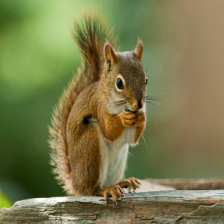

In [95]:
squirrel_image = Image.open('datasets/skquirrel.jpg').resize(IMAGE_SHAPE)
squirrel_image

Test model to see if its working

In [96]:
squirrel_image = np.array(squirrel_image)/255.0
squirrel_image[np.newaxis, ...].shape
result = classifier.predict(squirrel_image[np.newaxis, ...])
predicted_label_index = np.argmax(result)
with open("datasets/ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()

image_labels[predicted_label_index]

1/1 [==============================] - 0s 478ms/step


'fox squirrel'

### Now that we have the model loaded and working, we just need to load in the dataset and modify the model

### Load Dataset
All code is copy pasted from an earlier notebook 

In [97]:
ROOT_DIR = 'brawlhalla-data-legends/'


def get_sub_dirs(root_dir):
    classes = []
    for root_dir, dirs, files in os.walk(root_dir):
        if len(dirs) > 0:
            classes = dirs
    return classes


classes = get_sub_dirs(ROOT_DIR)
print(f'classes found {len(classes)}:')
for c in classes:
    print(c)

classes found 4:
0-bodvar
1-cassidy
2-lord-Vraxx
3-orion


In [98]:
# Variables
SIZE = 224
class_names = get_sub_dirs(ROOT_DIR)

# hardcoded
# Zero's represent images per legend (following legend order in game) -> Bodvar, Cassidy, Orion, Vraxx
legend_images = [0, 0, 0, 0]

# Functions

# there should be a way to remove the hardcoding here


def count_images_per_class(folder_name):
    if class_names[0] in str(folder_name):
        legend_images[0] += 1
    if class_names[1] in str(folder_name):
        legend_images[1] += 1
    if class_names[2] in str(folder_name):
        legend_images[2] += 1
    if class_names[3] in str(folder_name):
        legend_images[3] += 1


def load_image(file, SIZE):
    img = Image.open(file)
    img = img.resize((SIZE, SIZE))
    return np.array(img).flatten()


def load_labelled_images(path, SIZE):
    labels = list()
    files = list()
    for file_info in [x for x in Path(path).glob("**/*.jpg")]:
        labels.append(int(file_info.parts[1][0:1]))
        files.append(str(file_info))
        count_images_per_class(file_info)

    imgs = np.array([load_image(f, SIZE) for f in files])
    return imgs, np.array(labels)


# Load all images to the notebook
images, labels = load_labelled_images(ROOT_DIR, SIZE)
print("Loaded", len(images), "images in the following",
      len(np.unique(labels)), "classes:")

for label, image in zip(np.unique(labels), legend_images):
    print(f'{label} ({image})')

Loaded 146 images in the following 4 classes:
0 (31)
1 (44)
2 (39)
3 (32)


## Reshaping them

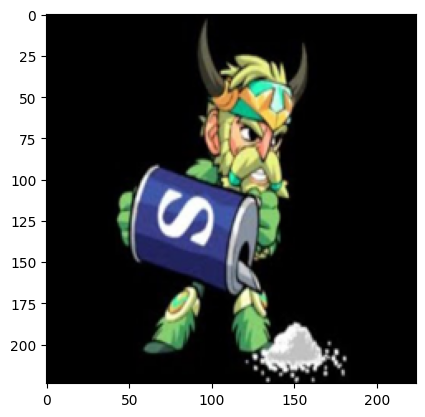

In [99]:
images = images.reshape(len(images), SIZE, SIZE, 3)
plt.imshow(images[0])

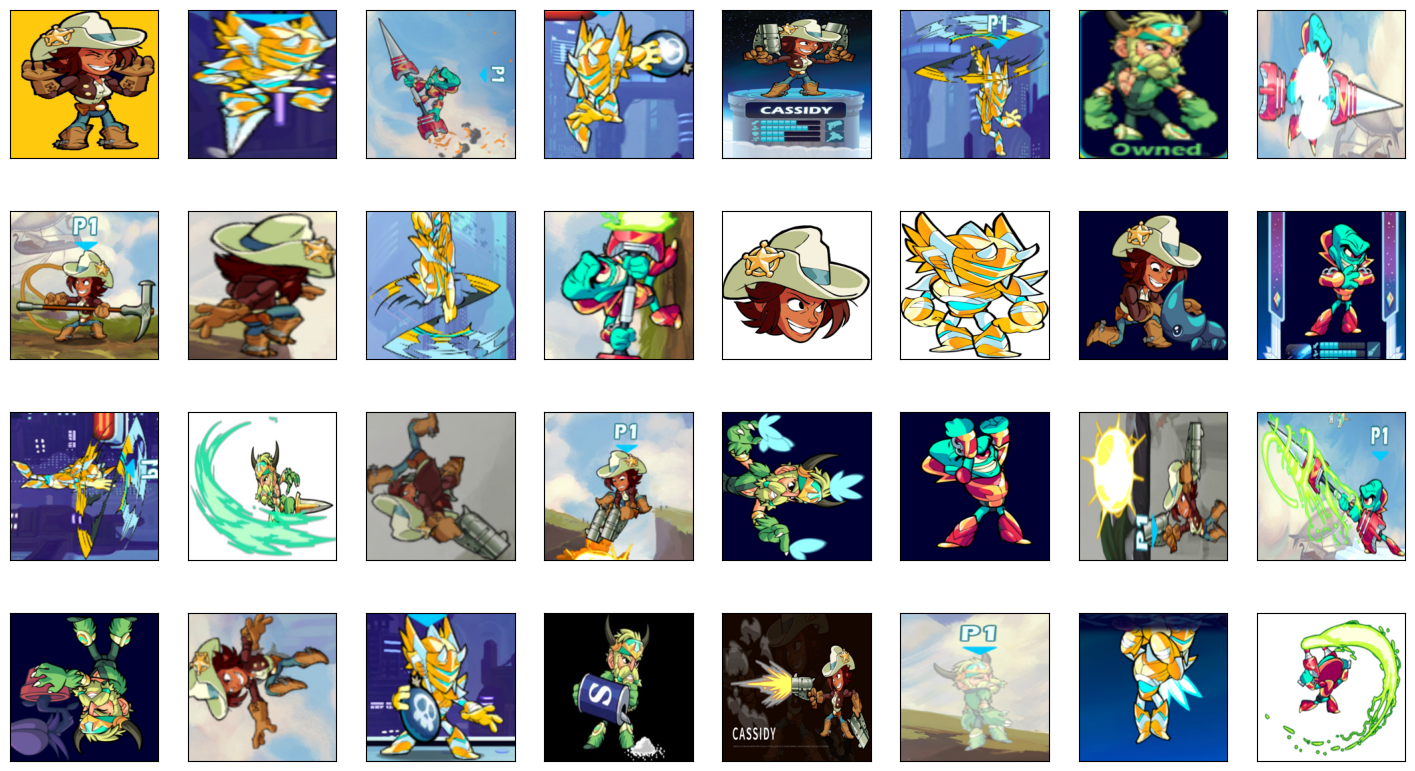

In [100]:
sample_size = 32

plotimgs = copy.deepcopy(images)
np.random.shuffle(plotimgs)
rows = plotimgs[:sample_size]

_, subplots = plt.subplots(nrows=math.ceil(
    sample_size/8), ncols=8, figsize=(18, int(sample_size/3)))
subplots = subplots.flatten()
for i, x in enumerate(rows):
    subplots[i].imshow(np.reshape(x, [SIZE, SIZE, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])

## split in train test

In [101]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=.2)

# X_train
y_test

array([0, 3, 2, 3, 1, 3, 2, 2, 0, 1, 2, 1, 0, 2, 3, 1, 2, 0, 2, 0, 1, 1,
       1, 2, 3, 2, 3, 2, 1, 3])

In [102]:
X_train.shape

(116, 224, 224, 3)

## Modify the model

In [103]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [104]:
num_of_legends = 4

model = tf.keras.Sequential([pretrained_model_without_top_layer,tf.keras.layers.Dense(num_of_legends)
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_9 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_3 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [113]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

model.fit(X_train, y_train, epochs=20)

Epoch 1/20
4/4 [==============================] - 3s 412ms/step - loss: 0.9467 - acc: 0.6638
Epoch 2/20
4/4 [==============================] - 2s 369ms/step - loss: 0.8322 - acc: 0.8190
Epoch 3/20
4/4 [==============================] - 2s 387ms/step - loss: 0.7565 - acc: 0.8362
Epoch 4/20
4/4 [==============================] - 2s 386ms/step - loss: 0.6889 - acc: 0.8362
Epoch 5/20
4/4 [==============================] - 1s 357ms/step - loss: 0.6458 - acc: 0.8276
Epoch 6/20
4/4 [==============================] - 1s 344ms/step - loss: 0.5877 - acc: 0.9138
Epoch 7/20
4/4 [==============================] - 2s 409ms/step - loss: 0.5522 - acc: 0.9224
Epoch 8/20
4/4 [==============================] - 2s 384ms/step - loss: 0.5078 - acc: 0.9310
Epoch 9/20
4/4 [==============================] - 2s 385ms/step - loss: 0.4756 - acc: 0.9138
Epoch 10/20
4/4 [==============================] - 2s 383ms/step - loss: 0.4388 - acc: 0.9397
Epoch 11/20
4/4 [==============================] - 2s 379ms/step - lo

In [114]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 828ms/step - loss: 0.6735 - acc: 0.7667


[0.6734650731086731, 0.7666666507720947]

## Evaulate Prediction

In [115]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                       100*np.max(predictions_array),
                                       class_names[true_label]),
             color=color)


def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(4))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

1/1 [==============================] - 1s 778ms/step


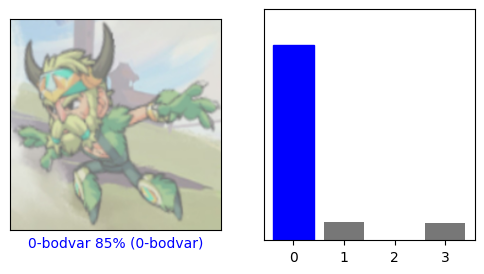

In [116]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test)

i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], y_test, X_test)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

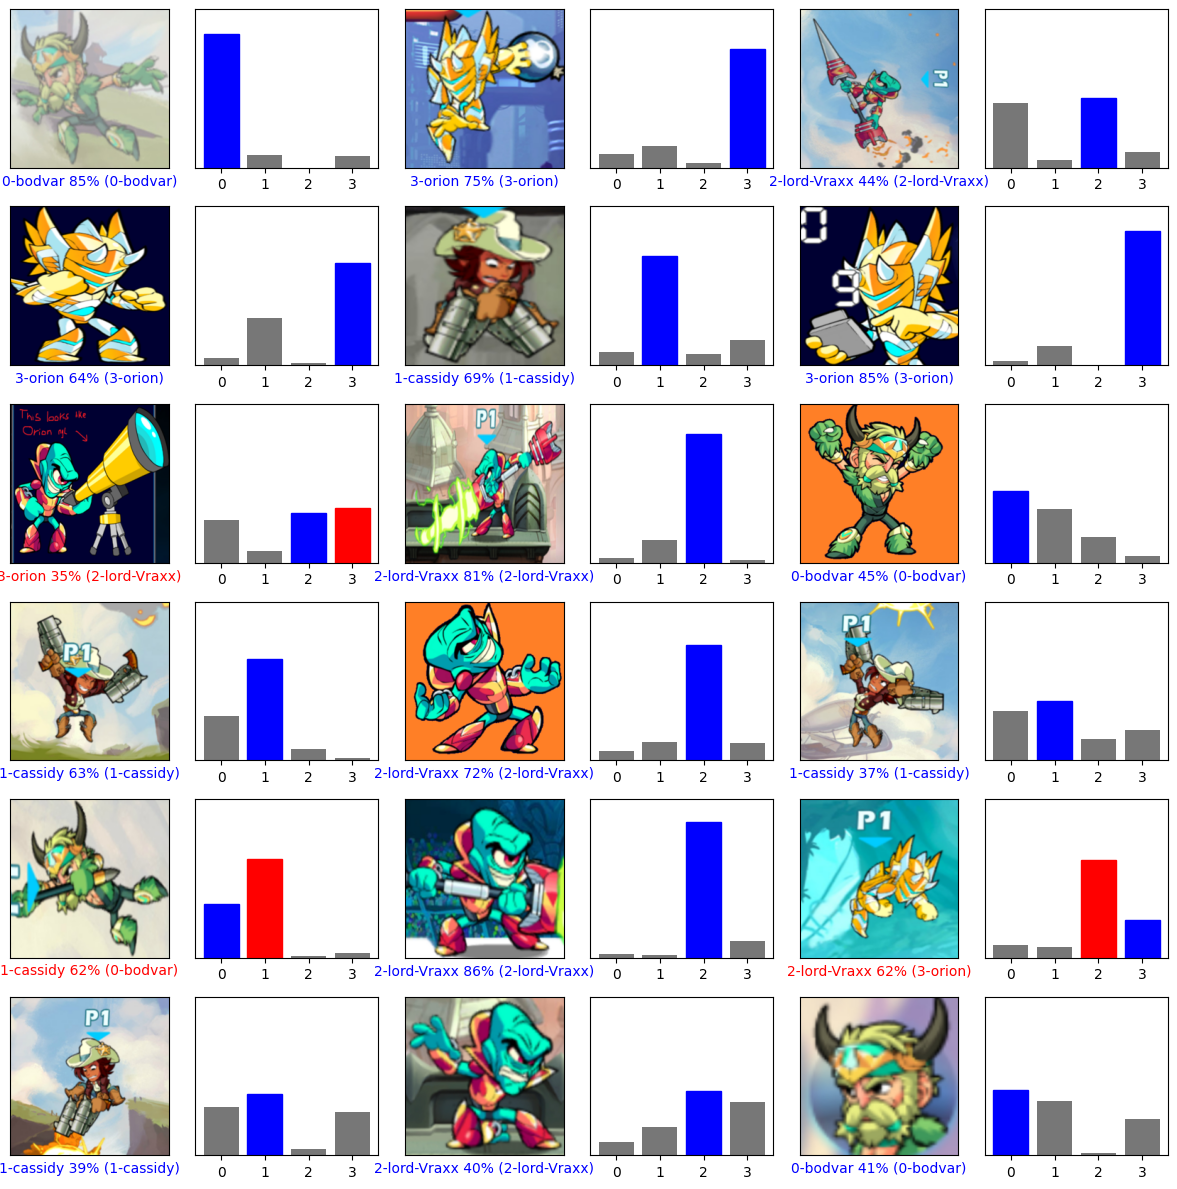

In [117]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 6
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

pretty nice, we probably have too few images of bodvar since it gets classified as cassidy multiple times. cassidy does have the most images so its not really a suprise.

Also cool how on the 7th image i wrote in red that it might confuse lord vrax (2) for orion (3) and it indeed got a high score for both 2 and 3 meaning it starts to think logically which is actually really cool.

accuracies
```
- 20 epochs - 60%
- 40 epochs - 76%
```

Tutorial i used: https://www.youtube.com/watch?v=LsdxvjLWkIY&ab_channel=codebasics